<font color="red">Before running the notebook, please make sure botoh files "Test" and "Train" are uploaded in the environment </font>

<h2>Anomaly Detection in Cellular network</h2>
<span> Link to Kaggle Site: </span><a href="https://www.kaggle.com/c/anomaly-detection-in-cellular-networks/overview"> https://www.kaggle.com/c/anomaly-detection-in-cellular-networks/overview</a>

<p>The design of a cellular network focuses on the optimization of energy and resources that guarantees a smooth operation even during peak hours (i.e. periods with higher traffic load). <br/>However, this implies that cells are most of the time overprovisioned of radio resources.
The goal of this study is to explore the possibilities of ML to detect abnormal behaviors in the utilization of the network that would motivate a change in the configuration of the base station.</p><br/>
The objective of the network optimization team is to analyze traces of past activity, which will be used to train an ML system capable of classifying samples of current activity as:
<ul>
<li><b>0 (normal):</b> current activity corresponds to normal behavior of any working day and. Therefore, no re-configuration or redistribution of resources is needed.</li>
<li><b>1 (unusual): </b>current activity slightly differs from the behavior usually observed for that time of the day (e.g. due to a strike, demonstration, sports event, etc.), which should trigger a reconfiguration of the base station.</li>
</ul>

---


<h3> Notes about the dataset:</h3>
The dataset has been obtained from a real LTE deployment. During two weeks, different metrics were gathered from a set of 10 base stations, each having a different number of cells, every 15 minutes. The dataset is provided in the form of a csv file, where each row corresponds to a sample obtained from one particular cell at a certain time. Each data example contains the following features:
<br/>
<li> <b>Time :</b> hour of the day (in the format hh:mm) when the sample was generated.
</li><li> <b>CellName1:</b> text string used to uniquely identify the cell that generated the current sample.   CellName is in the form xαLTE, where x identifies the base station, and α the cell within that base station (see the example in the right figure).
</li><li> <b>PRBUsageUL and PRBUsageDL: </b>level of resource utilization in that cell measured as the portion of Physical Radio Blocks (PRB) that were in use (%) in the previous 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
</li><li><b> meanThrDL and meanThrUL:</b> average carried traffic (in Mbps) during the past 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
</li><li><b> maxThrDL and maxThrUL: </b>maximum carried traffic (in Mbps) measured in the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
</li><li><b> meanUEDL and meanUEUL: </b>average number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
</li><li><b> maxUEDL and maxUEUL: </b>maximum number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
</li><li> <b>maxUE_UL+DL:</b> maximum number of user equipment (UE) devices that were active simultaneously in the last 15 minutes, regardless of UL and DL.
</li><li> <b>Unusual: </b>labels for supervised learning. A value of 0 determines that the sample corresponds to normal operation, a value of 1 identifies unusual behavior


---


<h1>Assignment:</h1>
<ol>
<li>Provide any insights into data that would be useful, as part of the summary</li>
<li>An unsupervised anomaly detection would be preferred but not required.</li>
</ol>



<h1> <font color="green">Definitions:</font></h1>

<ul>
<li><font color='blue'><b>Downlink: </b></font>Pertaining to GSM and cellular networks, the radio uplink is the transmission path from the mobile station (cell phone) to a base station (cell site). Traffic and signalling flowing within the BSS and NSS may also be identified as uplink and downlink.</li>
<li><font color='blue'><b>Uplink: </b></font>Pertaining to cellular networks, the radio downlink is the transmission path from a cell site to the cell phone. Traffic and signalling flowing within the base station subsystem (BSS) and network switching subsystem (NSS) may also be identified as uplink and downlink.</li>

<h2> Scoring: </h2>
The evaluation metric for this competition is Mean F1-Score. The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision p and recall r. Precision is the ratio of true positives  to all predicted positives . Recall is the ratio of true positives to all actual positives . The F1 score is given by:<br/><br/>
$$
 F1 = 2\frac{p \cdot r}{p+r}\ \ \mathrm{where}\ \ p = \frac{TP}{TP+FP},\ \ r = \frac{TP}{TP+FN}
$$
<br/><br/>
The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

In [1]:
!pip install statsmodels;

In [2]:
import warnings
# Math and DataFrame Processing
import pandas as pd
import numpy as np

# Python stats and ML Models
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import boxcox
from scipy import stats

import pickle

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn
import plotly.express as px


warnings.filterwarnings('ignore')

# 0.Helper Functions:
In this section we create some of the helper functions that are required during solving the problem:

In [3]:
# Dist_plot function is used to evaluate distribution of the features before and after our box-plot transformation
# The function receives the dataFrame and the column name and plots the whisker boxplot including the quartile ranges before and after transoformation
# It also plots the distribution of the parameter before and after transformation.

def dist_plot(df,column):
  fig, ax = plt.subplots(2,2,figsize=(10,10));
  fig.suptitle("Distribution for '"+ column+ "' column",fontsize=20)

  # -------------------BEFORE BOXCOX TRANFSORMATION
  ax[0,0].set_title(column+' Whisker Box Plot');
  ax[0,0].boxplot(
      [df[df['Unusual']==0][column],
        df[df['Unusual']==1][column]],
      positions=[1,2],
      labels=['Normal','Abnormal'],
      widths = 0.6
      );

  ax[0,1].set_title( column + ' Distribution');
  seaborn.distplot(df[df['Unusual']==0][column],hist_kws=dict(edgecolor="white", linewidth=2),ax=ax[0,1]);
  seaborn.distplot(df[df['Unusual']==1][column],hist_kws=dict(edgecolor="white", linewidth=2),ax=ax[0,1]);
  ax[0,1].legend(['Normal','Abnormal'])


  #-------------------BEFORE BOXCOX TRANFSORMATION
  df['Update'],lmbda = stats.boxcox(df[column]+0.001)
  ax[1,0].set_title(column+' Whisker Box Plot (After Transformation)');
  ax[1,0].boxplot(
      [df[df['Unusual']==0]['Update'],
        df[df['Unusual']==1]['Update']],
      positions=[1,2],
      labels=['Normal','Abnormal'],
      widths = 0.6
      );

  ax[1,1].set_title( column + ' BoxCox Distribution');
  seaborn.distplot(df[(df['Unusual']==0)]['Update'],hist_kws=dict(edgecolor="white", linewidth=2),ax=ax[1,1]);
  seaborn.distplot(df[df['Unusual']==1]['Update'],hist_kws=dict(edgecolor="white", linewidth=2),ax=ax[1,1]);
  ax[1,1].legend(['Normal','Abnormal'])
  ax[1,1].axvline(df[df['Unusual']==0]['Update'].mean(), alpha = 0.5,c='blue', dashes= (5, 2, 1, 2));
  ax[1,1].axvline(df[df['Unusual']==1]['Update'].mean(), alpha = 0.5,c='red', dashes= (5, 2, 1, 2));


In [4]:
# Pre_Process_Data function receives a dataframe as well as the status of the dataframe (Whether it is used for training or not)
# Before anything, the dataframe checks for missing values on the non-object datatypes and imputes them by replacing those values
# with the median value of the the remaining of the data. The reason a median was determined was due to skewness of the distribution and also existence of
# numerical (non-float).

# The pre-processing function performs transformation on all the columns with skewed distribution. The list of the columns are hard-coded
# within the function itself. The function returns the list of Lambda values that works best to normalize the distributions as part of the return
# values for this function.
# In addition, some transformation is also happening on the object datatypes. For instance:
#
#
# Time Column:
#   - The minute and the horus are being extracted from the datatype using datetime library and minutes from the beginning of the day is calculated
#   - The column type is subsequently changed to Int
#   - The Time column is eventually removed from DataFrame at the end of the function
#
# Cell Name: I separated the Cellname column into:
#   - Base Number: A value ranging from 1 to 10
#   - Cell Number: A value between "A","B","C","U","V","W"
#                  This column is subsequently encoded into additional x6 independant columns of 0 and ones. Both Cell Number column and the Cell name column are removed from
#                  DataFrame in the end
# The Lambda values that provides the best normal distribution fit for the skewed data is also returned as an array. The column transformations do not occur at this stage
# If the objective is only to perform feature engineering and imputation, instead of Training, the lambda values will no be calculated and the function will only perform imputation
# and Feature modification on Time and Cell Name columns and returns the updated dataframe

def Pre_Process_Data(df,Training):
  dfa = df.dropna()
  skewed_columns = ['PRBUsageUL', 'PRBUsageDL', 'meanThr_DL',
      'meanThr_UL', 'maxThr_DL', 'maxThr_UL', 'meanUE_DL', 'meanUE_UL',
      'maxUE_DL', 'maxUE_UL']

  Categorical_Columns = ['Time','CellName']
  BC_Lambda_List = {}
  Impute_Columns = df.columns.drop(Categorical_Columns)

  # Imputing all unacceptable values in the non-categorical columns to the median of the column itself
  for col in Impute_Columns:
    if df[col].dtypes == 'object':
      df.loc[df[col].str.isnumeric() != True,col] =df[df[col].str.isnumeric()==True][col].astype(float).median()
      df[col]=df[col].astype(float)
    if df[col].isna().sum()>0:
      df.loc[df[col].isna() == True,col] = df[col].dropna().astype(float).median()


  df['BaseNumber']=df['CellName'].str[:-3].str[:-1].astype(int)
  df['CellWithin']=df['CellName'].str[:-3].str[-1]
  df['MinuteToDay']=pd.to_datetime(df['Time'],format= '%H:%M').dt.hour *60 + pd.to_datetime(df['Time'],format= '%H:%M').dt.minute

  one_hot = pd.get_dummies(df['CellWithin'])
  df=df.drop(columns=['CellName','Time','CellWithin'])
  df = df.join(one_hot)
  df.sort_values(by=['MinuteToDay'])
  if Training==True:
    for col in skewed_columns:
      BC_Lambda_List[col]=stats.boxcox(np.array(df[col])+0.0000001)[1]
    return df,BC_Lambda_List
  else:
    return(df)



In [5]:
# In the transformer function the lambda values calculated in the previous function will update the distributions of the hard-coded
# columns.
# This function also generates three new featuers as follows:
#   - Traffic Deviation: Determines the difference between mean and maximum traffic (UL) and divides it to
#                        the difference between mean and maximum traffic (DL)
#   - Resource Utilization Ratio: Didiving DL and UL of Resource Utilization
#   - User Usage: Determines the difference between mean and maximum simultaneous user equipment used for UL and
#                 divides it by this difference for DL
# If the dataset is meant to be used for training purpose, the function splits it into test and training set with a ratio of 67-33
# and returns the X_train, X_test, Y_train and Y_test values.
# If the dataframe is going to be used independantly, for instance only for testing purpose, the modified dataframe
# is returned.


def transformer(df, lambda_values,Independant_Dataset):
  skewed_columns = ['PRBUsageUL', 'PRBUsageDL', 'meanThr_DL',
      'meanThr_UL', 'maxThr_DL', 'maxThr_UL', 'meanUE_DL', 'meanUE_UL',
      'maxUE_DL', 'maxUE_UL']
  for col in skewed_columns:
    df[col] = stats.boxcox(df[col]+0.01, lmbda=lambda_values[col])
    print(col+" : "+str(lambda_values[col]))
  df['Traffic_Deviation']=(df['maxThr_UL']-df['meanThr_UL'])/(df['maxThr_DL']-df['meanThr_DL'])
  df['ResourceUsage_Ratio']=df['PRBUsageDL']/df['PRBUsageUL']
  df['UE_Deviation']=(df['maxUE_UL']-df['meanUE_UL'])/(df['maxUE_DL']-df['meanUE_DL'])
  if (Independant_Dataset) == False:
    X_train, X_test, Y_train, Y_test = train_test_split(np.array(df.drop(columns=['Unusual'])),np.array(df['Unusual']), stratify=np.array(df['Unusual']), test_size=0.33, random_state=42)
    df_headers = df.columns.drop('Unusual')
    return(X_train, X_test, Y_train, Y_test,df_headers)
  else:
    return (df)

In [6]:
# Calculating F1 Score as per Kaggle's definition.

def F1_Calculator(cm):
  Precision = cm[1,1]/(cm[1,1]+cm[1,0])
  Recall =  cm[1,1]/(cm[1,1]+cm[0,1])
  F1 = 2*(Precision * Recall)/(Precision + Recall)
  return (np.around(100*F1,2))

In [7]:
# The get_VIF function will receive the dataFrame and target column (In this case, Unusual)
# and determines the Variable Inflation Factor for every independant variable. The purpose of this test
# is to determine a score reflecting that how much of each of these columns variability can be explained
# by variability of other columns. The higher the score of this factor, the more risk of multi-collinearity
# exists in doing the prediction.


def get_VIF(dataFrame , target):
    X = add_constant(dataFrame.loc[:, dataFrame.columns != target])
    seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns)
    return seriesObject


# 1. Analyzing the Data:

In [9]:
csv_url='https://raw.githubusercontent.com/vengie/AML-3104--Neural-Networks-and-Deep-Learning/main/ML-MATT-CompetitionQT1920_train.csv'
df_raw = pd.read_csv(csv_url,encoding="windows-1254")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36904 entries, 0 to 36903
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         36904 non-null  object 
 1   CellName     36904 non-null  object 
 2   PRBUsageUL   36904 non-null  float64
 3   PRBUsageDL   36904 non-null  float64
 4   meanThr_DL   36904 non-null  float64
 5   meanThr_UL   36904 non-null  float64
 6   maxThr_DL    36904 non-null  float64
 7   maxThr_UL    36904 non-null  float64
 8   meanUE_DL    36904 non-null  float64
 9   meanUE_UL    36904 non-null  float64
 10  maxUE_DL     36815 non-null  float64
 11  maxUE_UL     36815 non-null  float64
 12  maxUE_UL+DL  36899 non-null  object 
 13  Unusual      36904 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 3.9+ MB


In [10]:
Anomaly = len(df_raw[df_raw['Unusual']==1])
Normal = len(df_raw[df_raw['Unusual']==0])
Anomaly_Percentage = 100* (Anomaly)/(Anomaly+Normal)
print(f"Percentage of Anomaly data: {Anomaly_Percentage}%")

Percentage of Anomaly data: 27.593214827660958%


In [11]:
df_raw.head()

,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
0,10:45,3BLTE,11.642,1.393,0.370,0.041,15.655,0.644,1.114,1.025,4.0,3.0,7,1
1,9:45,1BLTE,21.791,1.891,0.537,0.268,10.273,1.154,1.353,1.085,6.0,4.0,10,1
2,7:45,9BLTE,0.498,0.398,0.015,0.010,0.262,0.164,0.995,0.995,1.0,1.0,2,1
3,2:45,4ALTE,1.891,1.095,0.940,0.024,60.715,0.825,1.035,0.995,2.0,2.0,4,1
4,3:30,10BLTE,0.303,0.404,0.016,0.013,0.348,0.168,1.011,1.011,2.0,1.0,3,0


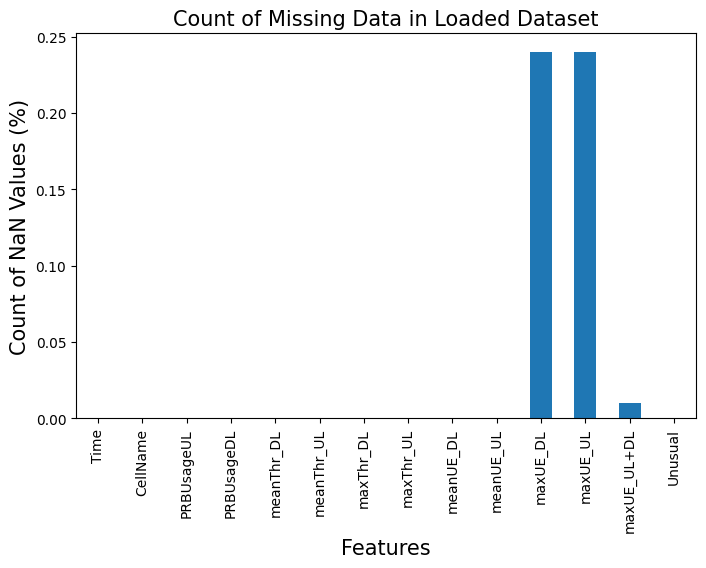

In [12]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
missingData = np.around(pd.read_csv(csv_url,encoding="windows-1254").isna().sum()*100/len(df_raw.index),2)
fig,ax = plt.subplots(1,1,figsize=(8,5));
ax = missingData.plot.bar();
ax.set_title("Count of Missing Data in Loaded Dataset", fontsize=15);
ax.set_xlabel("Features", fontsize=15);
ax.set_ylabel("Count of NaN Values (%)", fontsize=15);

## Missing Data Discussion:
As you can see, majority of the columns seem to be loaded properly except data related to User Equipment. <br/>
By sending the file into Pre_Process_Data function, we will be replacing this portion of the data with median values as explained in the function.<br/>


##Feature Engineering:<br/>
As per the instruction, CellNAme is a text string used to uniquely identify the cell that generated the current sample. CellName is in the form xαLTE, where x identifies the base station, and α the cell within that base station.
By splitting the cell name into the base number and the cell within the base, we were able to add another 7 columns to the dataset:


1.   Base Number which is a numeric parameter with 10 unique values
2.   Cell code that varies among 'A','B','C','U','V',or 'W'. For convenience and instead of using sklearn's one-hot encoder, I used pd_getdummies to expand the cell code into eigen vectors of length 6 and added them to the dataset as one-hot-encoded categorical variables.
3.   I also transformed the object column Time into minute from the beginning of the day. For instance, data recorded at 9:00 AM is recorded as 540 in the new future





In [13]:
df, lmbda = Pre_Process_Data(df_raw, Training=True)
print("Lambda factors for each column:\n")
X_train,X_test,Y_train,Y_test,cols = transformer(df, lmbda, Independant_Dataset=False)

Lambda factors for each column:

PRBUsageUL : 0.26115866643032826
PRBUsageDL : 0.16008404536884016
meanThr_DL : 0.24552723095001397
meanThr_UL : 0.19058176678820218
maxThr_DL : 0.3692110541690263
maxThr_UL : 0.13849725411255603
meanUE_DL : 0.9777432213445603
meanUE_UL : 0.26850692965446316
maxUE_DL : 0.5958433133367013
maxUE_UL : 0.514985603537697


## Data Visualization:
In this section we will be evaluating the data in terms of their distribution. <br/> We will be looking into possible differences in the mean and range of features for both normal and abnormal scenarios and see if we'd be able to identify significant differences between some of these values. <br/>


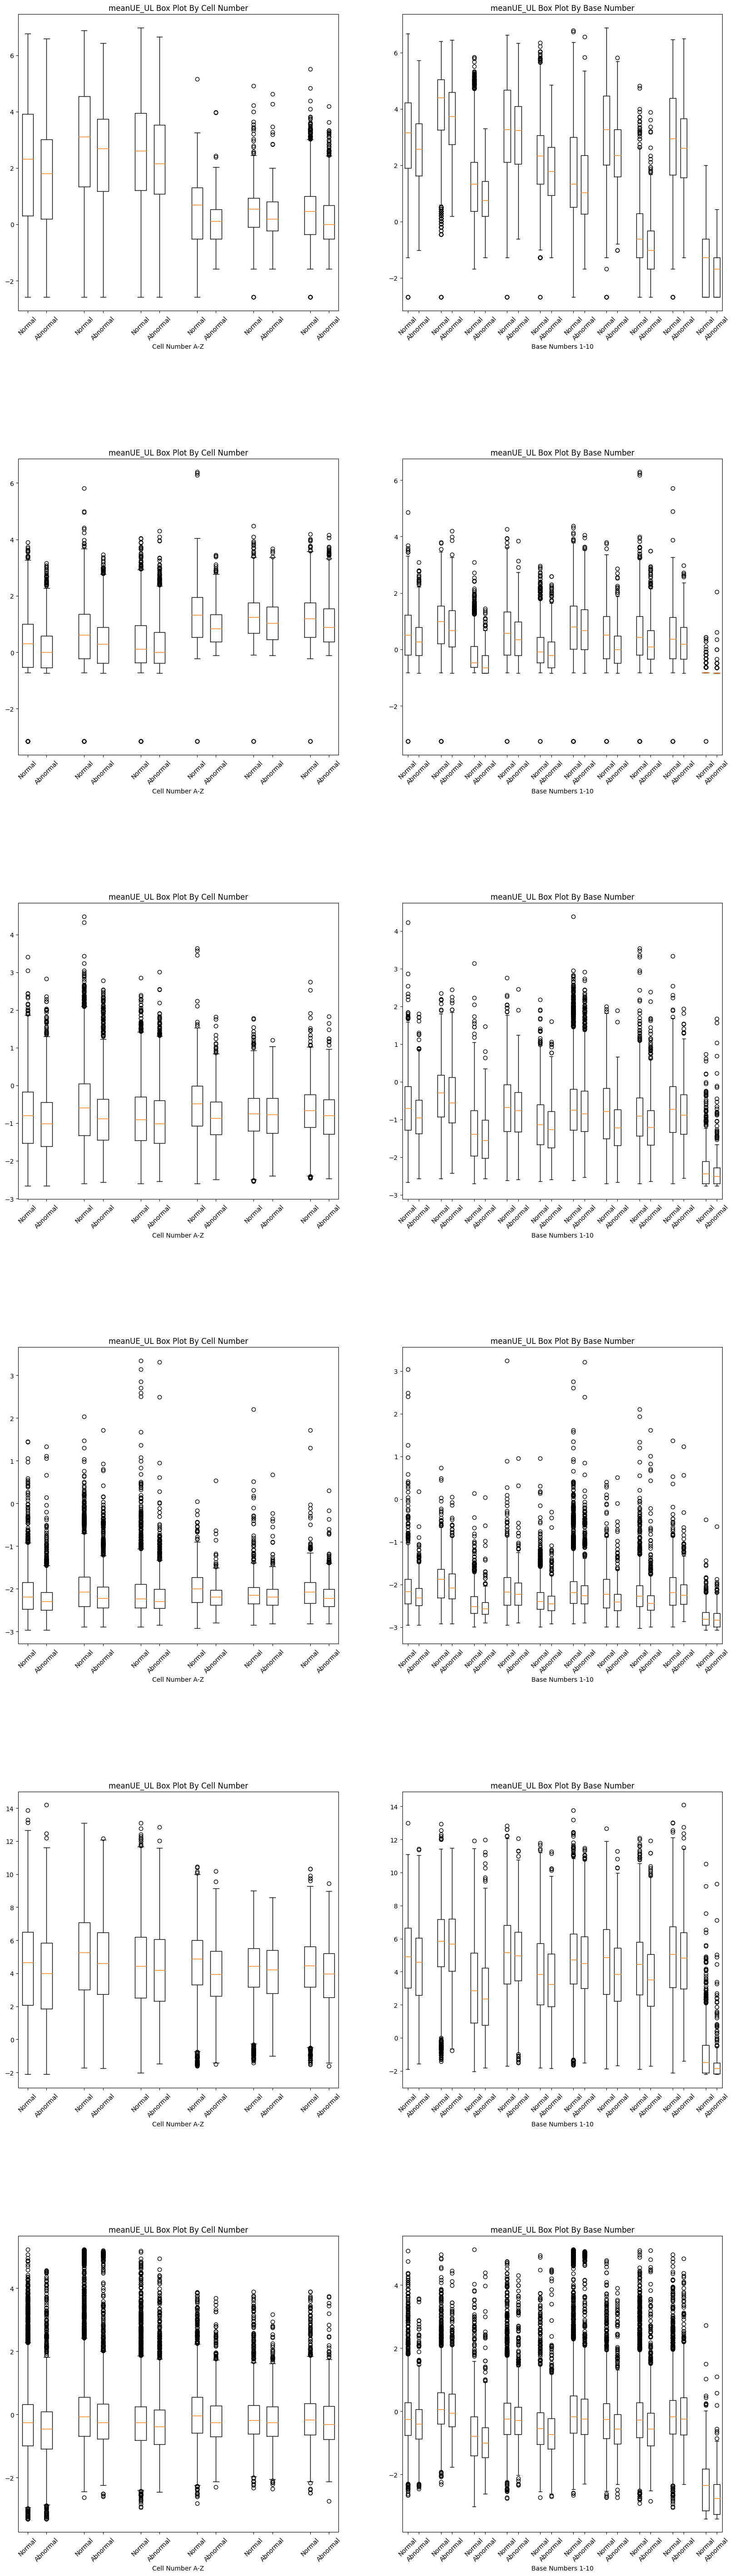

In [14]:

fig1, ax = plt.subplots(6,2,figsize=(20,12*6));
for j in range(6):
  Feature_of_interest = df.columns[j]
  ax[j,0].set_title(df.columns[7]+' Box Plot By Cell Number');
  ax[j,1].set_title(df.columns[7]+' Box Plot By Base Number');
  tower_labels=['A','B','C','U','V','W']
  plt.subplots_adjust(hspace = 0.5)
  i =0
  tower_anomaly = {}
  for tower in tower_labels:
    boxplot=[
        (0.1+df[(df['Unusual']==0) & df[tower]==1][Feature_of_interest]),
        (0.1+df[(df['Unusual']==1) & df[tower]==1][Feature_of_interest])
    ];
    ax[j,0].boxplot(
        boxplot,
        positions=[i*3,i*3+1],
        labels=['Normal','Abnormal'],
        widths = 0.6
        );
    ax[j,0].tick_params(axis='x', labelrotation=45)
    ax[j,0].set_xlabel('Cell Number A-Z')
    tower_anomaly[tower] = df[(df['Unusual']==1)&(df[tower]==1)][Feature_of_interest]
    i+=1
  i=1
  baseNumber_anomaly ={}
  for baseNumber in df['BaseNumber'].unique():
    boxplot=[
        (df[(df['Unusual']==0) & (df['BaseNumber']==baseNumber)][Feature_of_interest]),
        (df[(df['Unusual']==1) & (df['BaseNumber']==baseNumber)][Feature_of_interest] )
    ];
    ax[j,1].boxplot(
        boxplot,
        positions=[i*3,i*3+1],
        labels=['Normal','Abnormal'],
        widths = 0.6
        );
    ax[j,1].tick_params(axis='x', labelrotation=45)
    ax[j,1].set_xlabel('Base Numbers 1-10')
    baseNumber_anomaly[baseNumber] = df[(df['Unusual']==1)&(df['BaseNumber']==baseNumber)][Feature_of_interest]
    i+=1

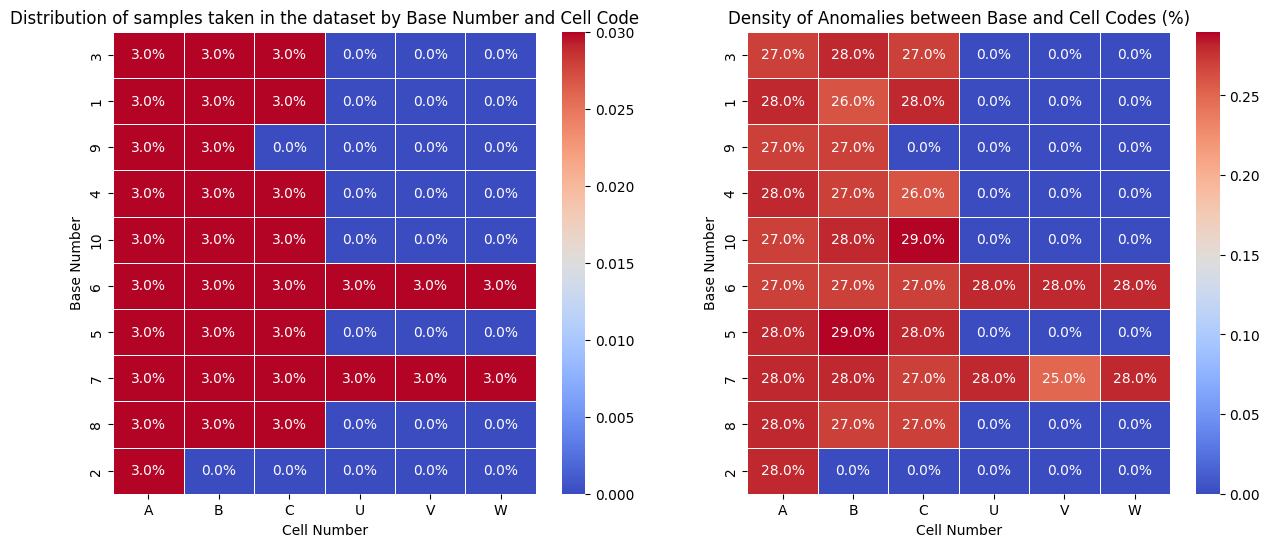

In [15]:
X = df['BaseNumber'].unique()
Y = ['A','B','C','U','V','W']
Z,q,Population,Pop = [],[],[],[]

for i in range(len(X)):
  q=[]
  Pop=[]
  for j in range(len(Y)):
    shortlisted = df[(df['BaseNumber']==X[i]) & (df[Y[j]]==1)]
    shortlisted_Anomaly = df[(df['BaseNumber']==X[i]) & (df[Y[j]]==1) & (df['Unusual']==1)]
    q.append(
        np.around(len(shortlisted)/len(df['BaseNumber']),2)
    )
    Pop.append(
        np.around(len(shortlisted_Anomaly)/(1+len(shortlisted)),2)
    )
  Z.append(q)
  Population.append(Pop)
fig,ax=plt.subplots(1,2,figsize=(15,6));
plt.title("Density of Anomalies between Base and Cell Codes (%)");
seaborn.heatmap(Z, xticklabels=Y, yticklabels=X, square=False , annot = True, ax=ax[0],linewidths=.5, cmap="coolwarm" , fmt='.1%');
ax[0].set_xlabel("Cell Number");
ax[0].set_ylabel("Base Number");
ax[0].set_title("Distribution of samples taken in the dataset by Base Number and Cell Code");

seaborn.heatmap(Population, xticklabels=Y, yticklabels=X, square=False , annot = True, ax=ax[1],linewidths=.5,cmap="coolwarm" ,fmt = '.1%');
ax[1].set_xlabel("Cell Number");
ax[1].set_ylabel("Base Number");
ax[1].set_title("Density of Anomalies between Base and Cell Codes (%)");


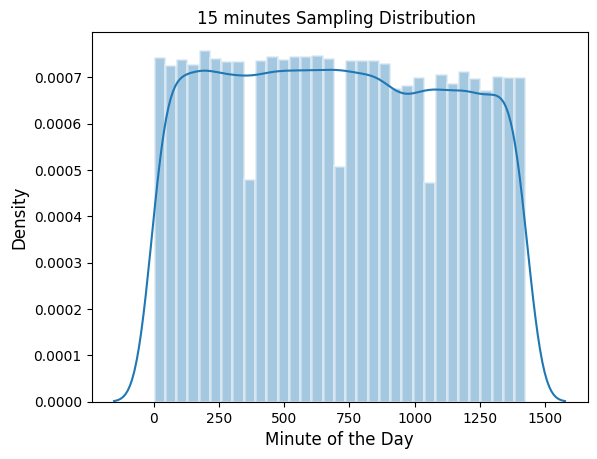

In [17]:
seaborn.distplot(df['MinuteToDay'],hist_kws=dict(edgecolor="white", linewidth=2));

plt.title('15 minutes Sampling Distribution ', fontsize=12);
plt.xlabel('Minute of the Day', fontsize=12);
plt.ylabel('Density', fontsize=12);

## Time Segments:
The data transformation mentioned earlier, transformed object datatypes to integer values pertaining the minutes elapsed from the beginning of the day. Looking at the training dataset, it seems like the samples follow a top-hat distribution with significant recording drops in 3 three times in the day which seem to be in 8 hours intervals.

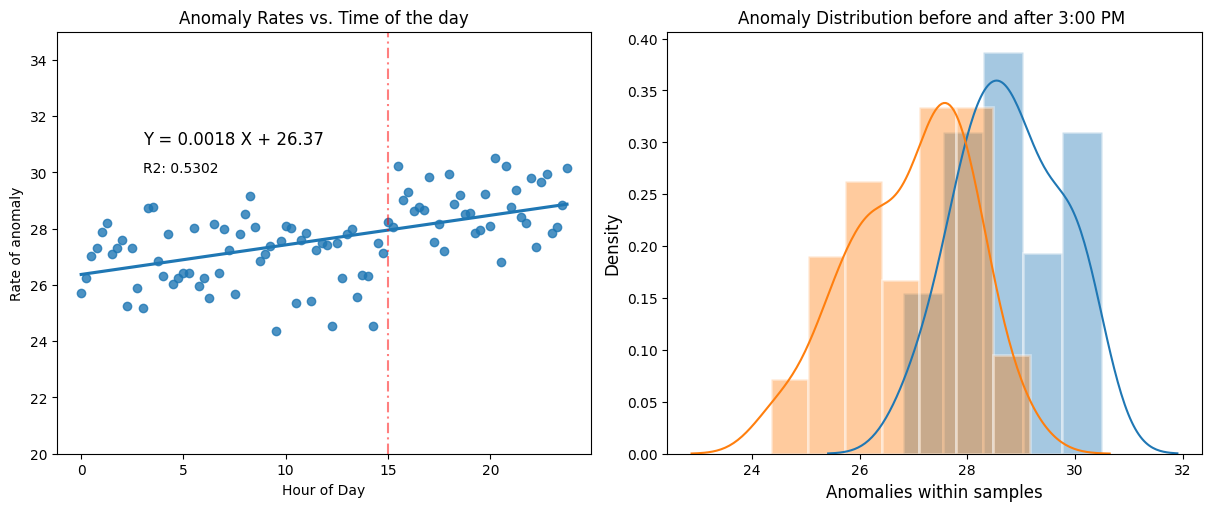

In [16]:
AnVsTime, above15,below15 = [],[],[]
for i in df['MinuteToDay'].unique():

  AnVsTime.append(
      100*len(df[(df['Unusual']==1) & (df['MinuteToDay']==i)]['MinuteToDay'])/len(df[df['MinuteToDay']==i])
  )
  if i>15*60:
    above15.append(
        100*len(df[(df['Unusual']==1) & (df['MinuteToDay']==i)]['MinuteToDay'])/len(df[df['MinuteToDay']==i])
    )
  else:
    below15.append(
        100*len(df[(df['Unusual']==1) & (df['MinuteToDay']==i)]['MinuteToDay'])/len(df[df['MinuteToDay']==i])
    )

from scipy import stats

slope, intercept, r_value, pv, se = stats.linregress(df['MinuteToDay'].unique(),AnVsTime)

fig, ax = plt.subplots(1,2,figsize=(12,5),constrained_layout=True)
seaborn.regplot(x=df['MinuteToDay'].unique()/60, y=AnVsTime,
  ci=None, label="y={0:.6f}x+{1:.1f}".format(slope, intercept), ax=ax[0])

ax[0].set_ylim([20,35])
ax[0].text(3,31,'Y = '+str(np.around(slope,4))+' X + '+str(np.around(intercept,2)), fontsize=12);
ax[0].text(3,30,'R2: '+str(np.around(r_value,4)));
ax[0].axvline(15, alpha = 0.5,c='red', dashes= (5, 2, 1, 2));
ax[0].set_title("Anomaly Rates vs. Time of the day")
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Rate of anomaly')
seaborn.distplot(above15,hist_kws=dict(edgecolor="white", linewidth=2),ax=ax[1]);
seaborn.distplot(below15,hist_kws=dict(edgecolor="white", linewidth=2),ax=ax[1]);

ax[1].set_title('Anomaly Distribution before and after 3:00 PM ', fontsize=12);
ax[1].set_xlabel('Anomalies within samples', fontsize=12);
ax[1].set_ylabel('Density', fontsize=12);


##Anomalies across Hours of the day:
<p>Just to explore the anomaly rates recorded across the hours of the day I developed a scatterplot that exhibits a positive correlation between time of the day and anomaly rate. </p>

<p>Given the very low slope value of the correlation and the fact that the model is only able to explain 51% of variation in the data, at first glance I decided to ignore this subtle correlation. However, looking at the dataset, a shift in the anomaly rates is apparent after 3:00 PM in the dataset that exhibits a logistic correlation at this point. </p>

<p>Just for purpose of exploration I visually looked at the normal distribution in the data before and after 3:00 PM and it does look like there has been a shift in the anomalies at this point in time. </p>


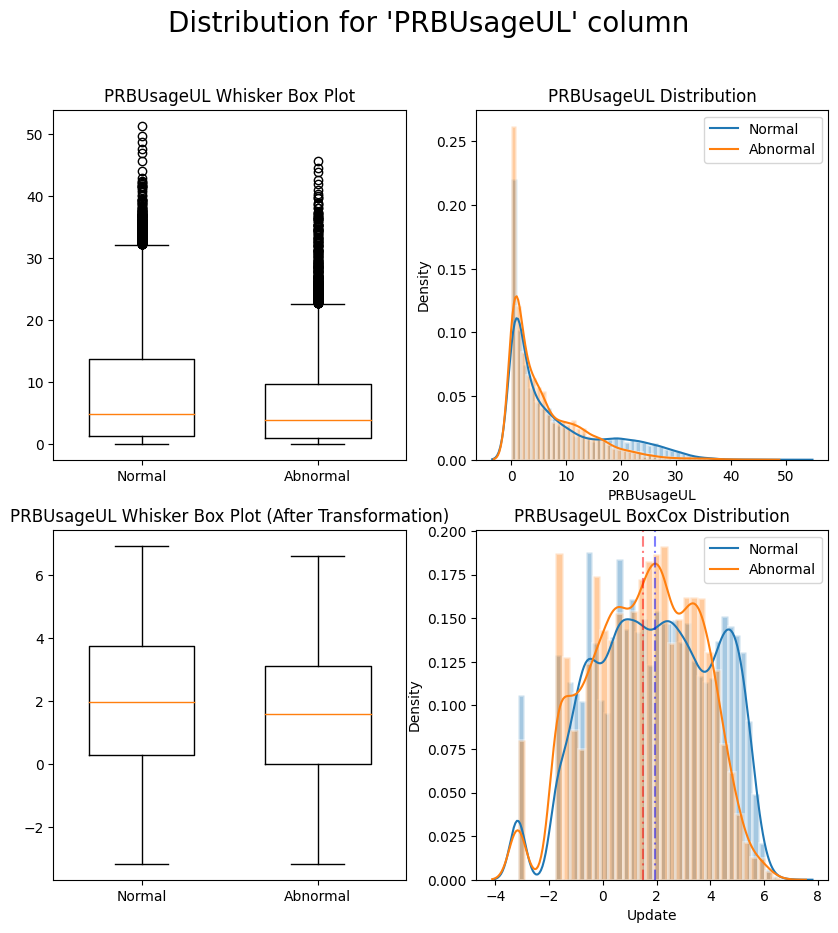

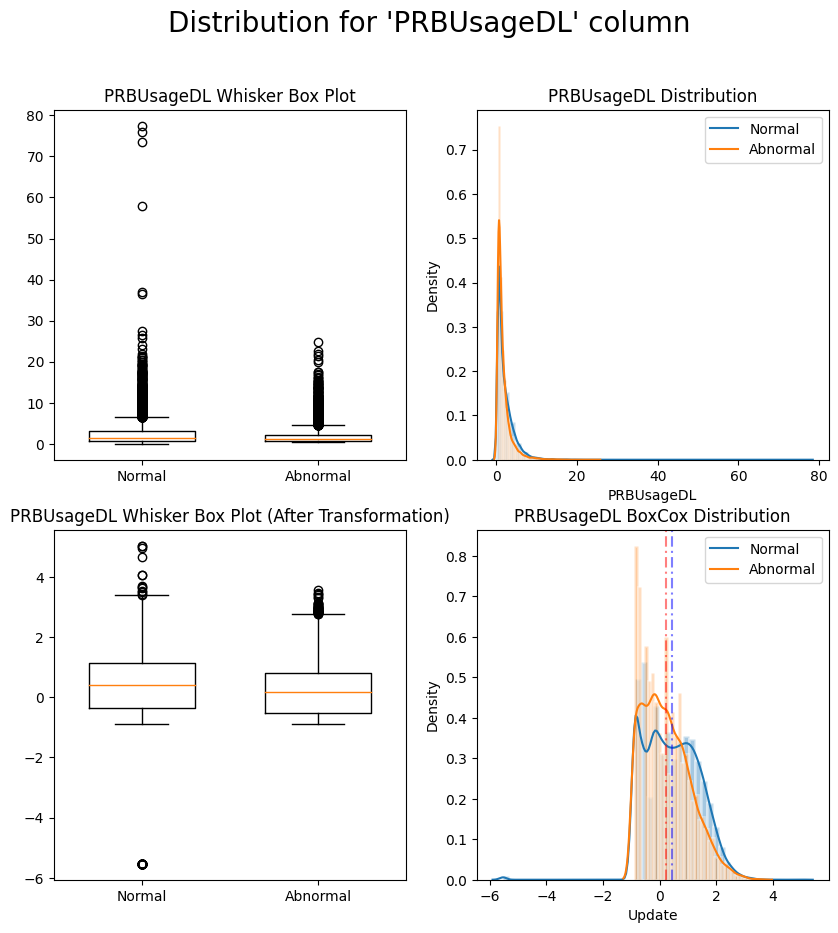

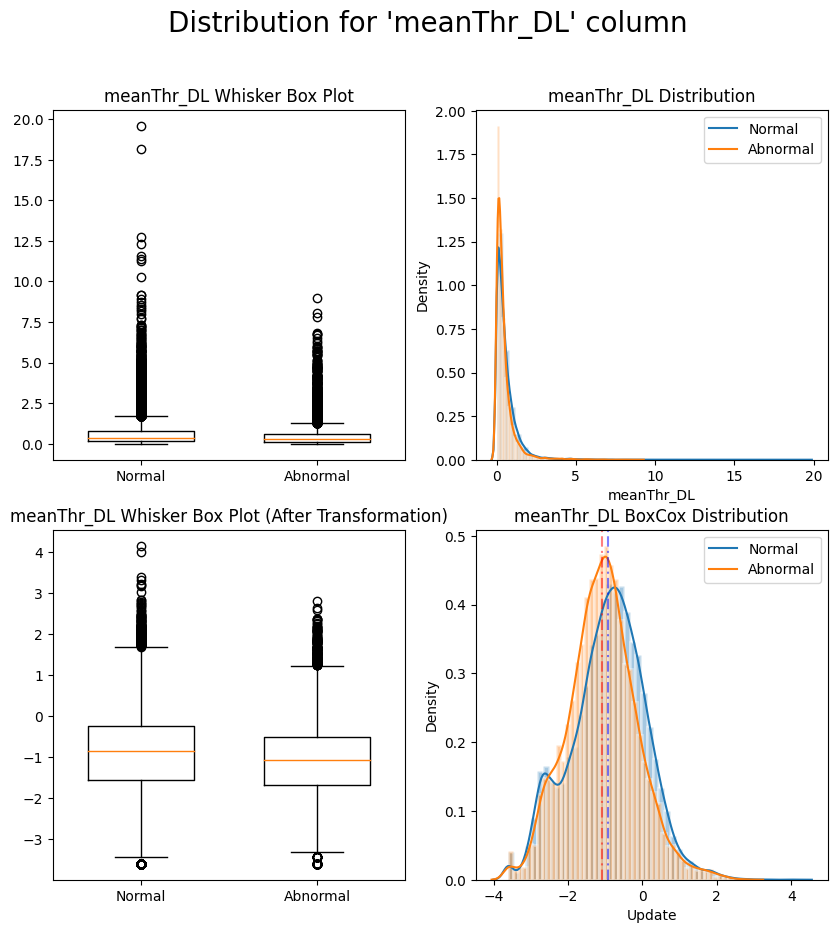

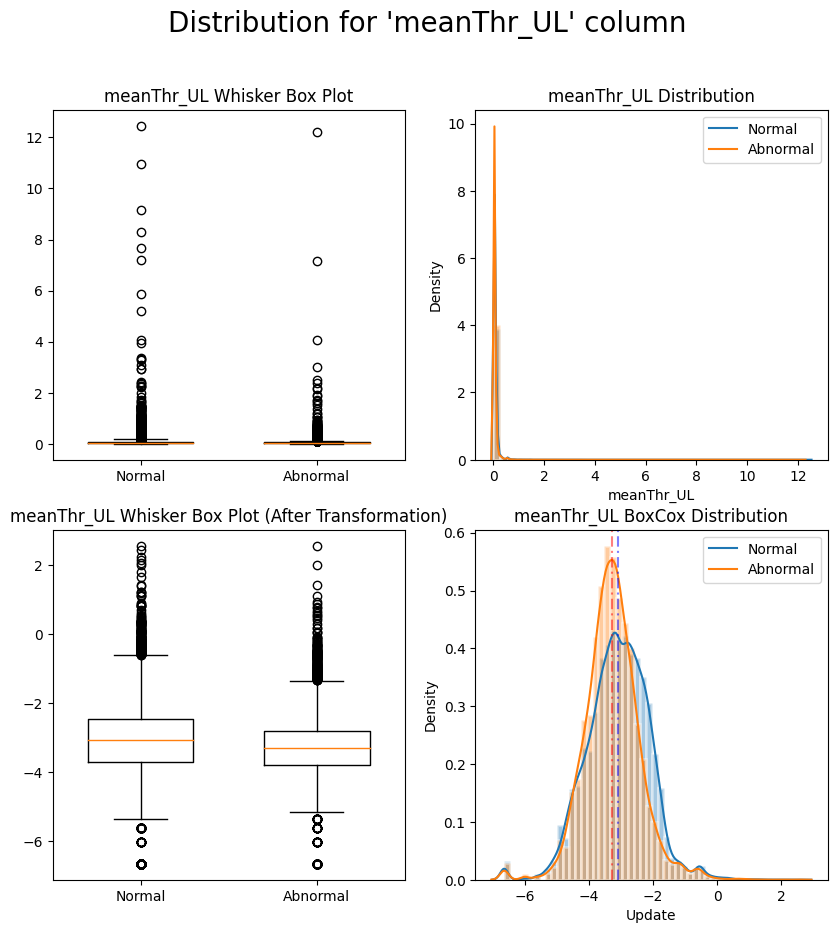

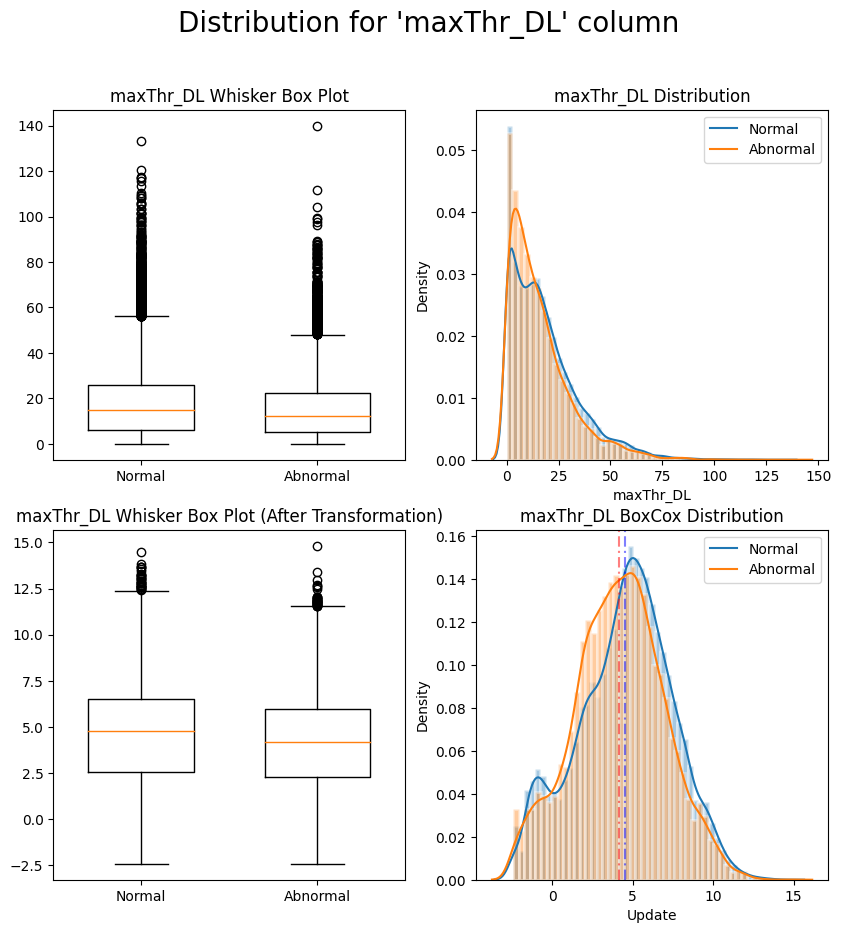

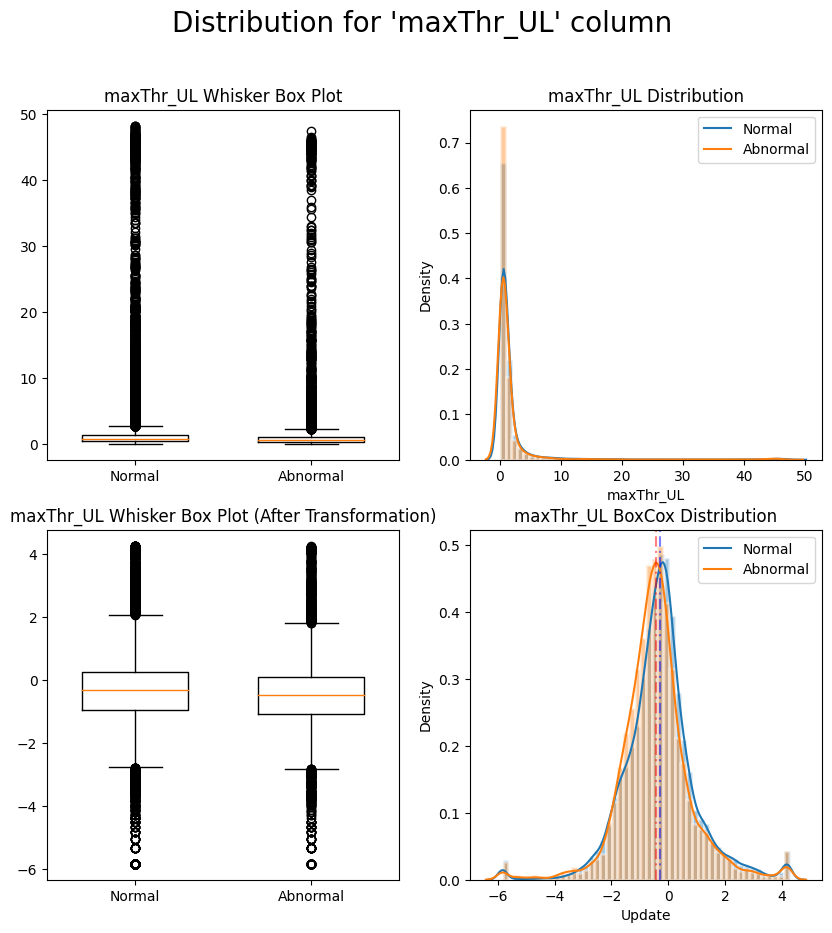

In [18]:
for i in range(6):
  dist_plot(df_raw,df_raw.columns[i+2])

TypeError: ignored

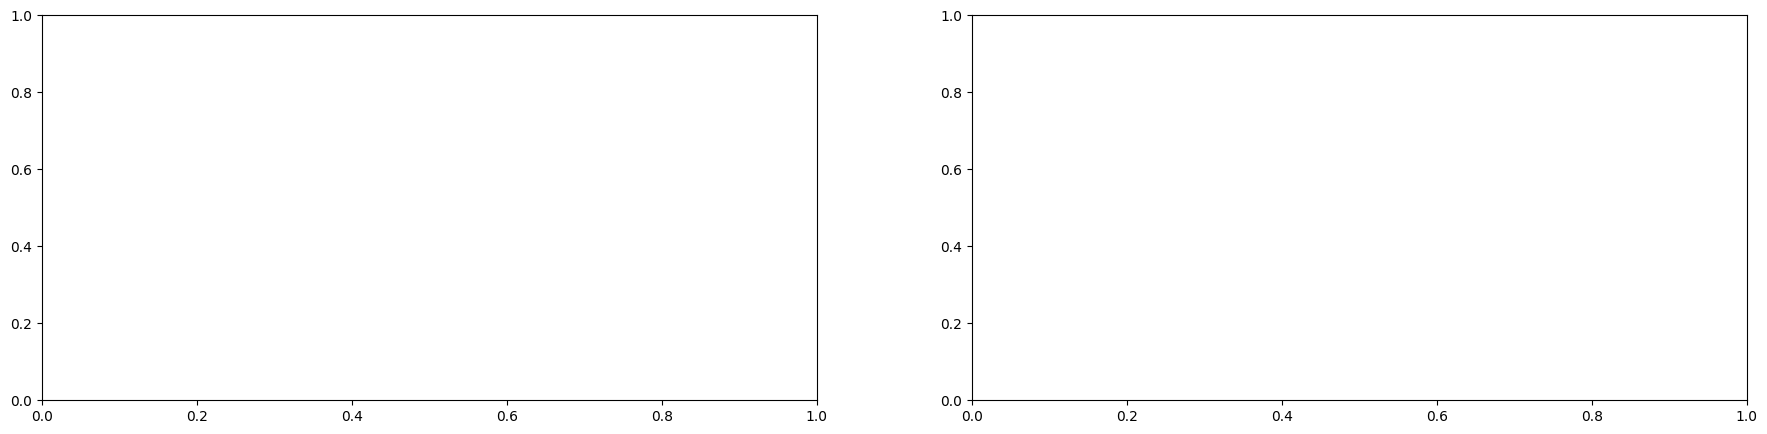

In [19]:

fig, ax = plt.subplots(1,2,figsize=(22,5));
seaborn.scatterplot((df['maxThr_DL']),df['meanThr_DL'], data=df, hue='Unusual',ax=ax[0]);
seaborn.scatterplot((df['maxThr_UL']),df['meanThr_UL'], data=df, hue='Unusual',ax=ax[1]);
ax[0].set_title('Downlink - Correlation between Mean and Maximum Carried Traffic');
ax[1].set_title('Uplink - Correlation between Mean and Maximum Carried Traffic');


As observed, there seem to be a linear positive correlation between the two factors which was anticipated. This correlation will cause Multi-Collinearity in the final model we use and therefore not desirable. So my approach would be to transform them into a separate feature
I also decided to combine the mean and max features for both Uplink and Downlink data by

In [ ]:

F1Score = []

fig = px.scatter_3d(df, z=df['ResourceUsage_Ratio'],y=np.log(df['Traffic_Deviation']), x = df['UE_Deviation'] ,color='Unusual',width=800, height=600, opacity=0.6,size_max=3)
fig.update_layout(
    margin=dict(l=20, r=20, t=40, b=50),
    paper_bgcolor='rgba(250,250,250,1)',
    title="3D Scatter Plot between Engineered Features ",
    title_font_size=24
)
fig.show()

In [ ]:

F1Score = []

components = 2
pca = PCA(n_components=components)
X_train_PCA = pca.fit_transform(X_train)

df_PCA = pd.DataFrame(data=X_train_PCA,columns=['Z2','Z3'])
fig = px.scatter_3d(df_PCA, x='Z2',y='Z2', z = 'Z3' ,color=Y_train,width=800, height=600, opacity=0.6,size_max=3)
fig.update_layout(
    margin=dict(l=20, r=20, t=40, b=50),
    paper_bgcolor='rgba(250,250,250,1)',
    title="PCA N_Components: "+str(components),
    title_font_size=24
)
fig.show()

**Multi-collinearity and independant variables dependency:**
<br/><br/>
In the next section we check our continuous variables for possible multi-collinearity. Multi-collinearity is a feature of data where your independent variable can be predicted from another independent variable in a regression model. <br/>
Presence of multi-collinearity will:
<ol>
<li>Make it hard for you to choose the list of significant variables for the model if the model gives you different results every time.</li><li>
Result in unstability of the Coefficient Estimates. In that case changing one of your input variables by a small unit will result in unproportional changes to the output.</li><li>
Result in over-fitting. </li>
</ol>

Here we utilized a statsmodel built-in function, "Variance_Inflation_Factor" which calculates the R_square value of all the features in your dataset in relation to other input variables.
$$VIF = 1/(1-R^2)$$
With the formula shown above, we can argue that the closer the correlation between variables get to one (e.g. perfect correlation), the VIF value will subsequently increase. <br/>

This indicator helps us filter out some of the parameters with multi-collinearity during our analysis.



**Result Interpretation for VIF Analysis:** </br>
As you can see above, the VIF factor for majority of our non-categorical data has variability inflation factor of below 5. This means that for most of them, the Coefficient of Determination (R_square) was below 80%. <br/>
In case of the following 3 parameters, the VIF value was significantly large due to perfect correlation between these variables:

*   maxUE_UL+DL
*   maxUE_UL
*   maxUE_DL

This makes complete sense. In fact, by taking a quick glance at the data, you'll see that maxUE_UL+DL is a product of linear combination of the other two columns. By eliminating





In [ ]:
target = "Unusual"
ss = get_VIF(df.drop(columns=['A','B','C','U','V','W']),target)
ss=ss.drop(labels=['const'])
ss.sort_values(ascending=False).plot.bar();
plt.title("VIF Factor for All Features")

df_Train = pd.DataFrame(X_train,columns=cols).drop(columns=ss[ss>3].keys())
df_Test = pd.DataFrame(X_test,columns=cols).drop(columns=ss[ss>3].keys())
print("Reduced dataFrame (VIF<4): \n")
print(df_Train.info())



In [ ]:
fig,ax = plt.subplots(1,2,figsize=(24,10));
seaborn.heatmap(df.drop(columns=['Unusual']).corr(),annot=True, cmap="coolwarm",ax=ax[0]);
seaborn.heatmap(df_Train.corr(),annot=True, cmap="coolwarm", ax=ax[1]);
ax[0].set_title('Before eliminating maxUE_UL+DL',fontsize=18);
ax[1].set_title('After eliminating maxUE_UL+DL',fontsize=18);

**Data Preparation:**<br/>
At this stage we will proceed with preparing the data for modeling. Since we have already encoded our attribute data, we will only focus on the numerical aspect of the dataset and pass them through a StandardScaler pipeline.  

In [ ]:

X_test = np.array(df_Test)

X_train = np.array(df_Train)

scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(np.array(df_Train))
X_test_scale = scaler.transform(np.array(df_Test))




print("Total Y_Train Rows: "+str(len(Y_train))+ ' & % Anomaly: '+str(np.count_nonzero(Y_train)/len(Y_train)))
print("Total Y_Test Rows: "+str(len(Y_test))+ ' & % Anomaly: '+str(np.count_nonzero(Y_test)/len(Y_test)))

**Qualitative Dimensionality Reduction (PCA):**

For visualization purpose, I decided to reduce the dimensions into 3 Eigen vector with colors representing the entry class of 0 being normal or 1 being the anomaly. The volume of the anomaly data as well as non-linearity in the data did not provide us with a proper visualization between the labels.

**Data Transformation:**
<br/> The above code performs standard scaler transformation on the remaining features of our X dataset. In addition, it breaks down the dataset into Training and Test sets on both featuers and output with a ratio of 33%. <br/> Since we are dealing an imbalanced dataset, the train_test_split function ensures that the imbalanced nature of the dataset is preserved via stratified sampling. As it's shown above, the original dataset, test dataset as well as train dataset preserved the ~28% anomaly rates that exist in the original dataset.

#Modeling:
When it comes to modeling, we will be implementing the following two algorithms and evaluate their performance:

**KNN Model:**<br/>
KNN is a non-parametric classification model that is used for classification and regression. In both cases, the input consists of the k closest training examples in data set.

**XG-Boost Method:**
<br/>The following code snippet performs modeling on the Training dataset using XG Boost technique. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

<h1> K-Nearest Neighbor </h1>

In [ ]:

Model_KNN = KNeighborsClassifier()
model_Results_KNN = Model_KNN.fit(X_train_scale, Y_train)
score_KNN = cross_val_score(KNeighborsClassifier(),
    X_train_scale, Y_train, cv=150, scoring='accuracy')

Y_predict_Train = Model_KNN.predict(X_train_scale)

cm_KNN_Train=confusion_matrix(Model_KNN.predict(X_train_scale),Y_train)
cm_KNN_Test=confusion_matrix(Model_KNN.predict(X_test_scale),Y_test)

print("Model Accuracy (F1 Score) on Training Set: " + str(F1_Calculator(cm_KNN_Train))+"%")
print("Model Accuracy (F1 Score) on Test Set: " + str(F1_Calculator(cm_KNN_Test))+"%")

# ----------------------------------------------- Plotting Results ---------------------------------------------------------
fig,ax = plt.subplots(2,2,figsize=(15,13));
seaborn.heatmap(cm_KNN_Train, annot=True, fmt='', cmap='Blues', ax=ax[0,0]);
ax[0,0].set_title("Confusion Matrix for KNN - Training Set");
seaborn.heatmap(cm_KNN_Test, annot=True, fmt='', cmap='Reds', ax=ax[0,1]);
ax[0,1].set_title("Confusion Matrix for KNN - Test Set");

seaborn.distplot(score_KNN,hist_kws=dict(edgecolor="white", linewidth=2),ax=ax[1,0]);
ax[1,0].set_title('Model Accuracy Score after 150 Cross-Validation');
ax[1,0].text(score_KNN.mean()*1.02,10,'Accuracy = '+str(np.around(100*score_KNN.mean(),2))+" %", fontsize=12);
ax[1,0].axvline(score_KNN.mean(), alpha = 0.5,c='red', dashes= (5, 2, 1, 2));

y_pred_proba = Model_KNN.predict_proba(X_test_scale)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

ax[1,1].plot(fpr,tpr,label="data 1, auc="+str(auc));
ax[1,1].plot(Y_test,Y_test);
ax[1,1].legend(loc=4);
ax[1,1].set_title("ROC Curve");
ax[1,1].set_xlabel("False Positive Rate");
ax[1,1].set_ylabel("True Positive Rate");

**K Nearest Neighbor Outcome:** <br/>
1.   Model Accuracy (F1 Score) on Training set: 54.5%
2.   Model Accuracy (F1 Score) on Test set: 33.1%


<p>The KNN model employed did not exhibit the performance we observed with the XGBOOST method. In the training dataset, the model was able to properly predict the false negatives however did a poor performance on the positive side. </p>
<p>KNN models, although have a significant advantage in fast convergence, but are sensitive to the noise in the data as well as high dimensionality. In an attempt to improve the performance, I decided perform Principle Component Analysis to reduce the dimensionality of the dataset.</p> <p>To replicate the gridsearch for optimum PCA number of components, I ran the module inside a loop with incrementing number of components from 2 to 12:</p>

In [ ]:

grid_params = {
    'n_neighbors':[2,5,10,50,int(np.log(X_train.shape[0]))],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

Model_KNN = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose = 4,
    cv = 3,
    n_jobs = 3
);
model_Results_KNN = Model_KNN.fit(X_train_scale, Y_train)
score_KNN = cross_val_score(KNeighborsClassifier(),
    X_train_scale, Y_train, cv=150, scoring='accuracy')

Y_predict_Train = Model_KNN.predict(X_train_scale)

cm_KNN_Train=confusion_matrix(Model_KNN.predict(X_train_scale),Y_train)
cm_KNN_Test=confusion_matrix(Model_KNN.predict(X_test_scale),Y_test)

print("Model Accuracy (F1 Score) on Training Set: " + str(F1_Calculator(cm_KNN_Train))+"%")
print("Model Accuracy (F1 Score) on Test Set: " + str(F1_Calculator(cm_KNN_Test))+"%")
print("\n Model Best Parameters: \n")
print(Model_KNN.best_params_)
# ----------------------------------------------- Plotting Results ---------------------------------------------------------
fig,ax = plt.subplots(2,2,figsize=(15,13));
seaborn.heatmap(cm_KNN_Train, annot=True, fmt='', cmap='Blues', ax=ax[0,0]);
ax[0,0].set_title("Confusion Matrix for KNN - Training Set");
seaborn.heatmap(cm_KNN_Test, annot=True, fmt='', cmap='Reds', ax=ax[0,1]);
ax[0,1].set_title("Confusion Matrix for KNN - Test Set");

seaborn.distplot(score_KNN,hist_kws=dict(edgecolor="white", linewidth=2),ax=ax[1,0]);
ax[1,0].set_title('Model Accuracy Score after 150 Cross-Validation');
ax[1,0].text(score_KNN.mean()*1.02,10,'Accuracy = '+str(np.around(100*score_KNN.mean(),2))+" %", fontsize=12);
ax[1,0].axvline(score_KNN.mean(), alpha = 0.5,c='red', dashes= (5, 2, 1, 2));

y_pred_proba = Model_KNN.predict_proba(X_test_scale)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

ax[1,1].plot(fpr,tpr,label="data 1, auc="+str(auc));
ax[1,1].plot(Y_test,Y_test);
ax[1,1].legend(loc=4);
ax[1,1].set_title("ROC Curve");
ax[1,1].set_xlabel("False Positive Rate");
ax[1,1].set_ylabel("True Positive Rate");

<h1> K-Nearest Neighbor - Optimized Principal Component Analysis (PCA):</h1>

In [ ]:

F1Score = []
grid_params = {
    'n_neighbors':[10],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}
for i in range(2,12,1):
  pca = PCA(n_components=i)
  pca.fit(X_train_scale)
  X_train_PCA = pca.transform(X_train_scale)

  Model_KNN_PCA = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      verbose = 4,
      cv = 3,
      n_jobs = 3
  );
  model_Results_KNN_PCA = Model_KNN_PCA.fit(X_train_PCA, Y_train)
  Y_predict_Train = Model_KNN_PCA.predict(X_train_PCA)

  cm_KNN = confusion_matrix(Y_train, Y_predict_Train)
  F1Score.append(F1_Calculator(cm_KNN))


# ---- BEST PCA Result

components = F1Score.index(max(F1Score))+2
pca = PCA(n_components=components)
X_train_PCA = pca.fit_transform(X_train_scale)
model_Results_KNN_PCA = Model_KNN_PCA.fit(X_train_PCA, Y_train)
X_test_PCA = pca.transform(X_test_scale)
cm_KNN_PCA_Train=confusion_matrix(Model_KNN_PCA.predict(X_train_PCA),Y_train)
cm_KNN_PCA_Test=confusion_matrix(Model_KNN_PCA.predict(X_test_PCA),Y_test)

print("\n Prediction Results:")
print("Model Accuracy (F1 Score) on Training Set: " + str(F1_Calculator(cm_KNN_PCA_Train))+"%")
print("Model Accuracy (F1 Score) on Test Set: " + str(F1_Calculator(cm_KNN_PCA_Test))+"%")
print("Best number of components during PCA transformation: " + str(components))


fig,ax = plt.subplots(1,3,figsize=(21,6));
seaborn.heatmap(cm_KNN_PCA_Train, annot=True, fmt='', cmap='Blues', ax=ax[0]);
ax[0].set_title("Confusion Matrix for KNN - Featured Reduction via PCA");
seaborn.heatmap(cm_KNN_PCA_Test, annot=True, fmt='', cmap='Reds', ax=ax[1]);
ax[1].set_title("Confusion Matrix for KNN - Featured Reduction via PCA");

ax[2].plot(range(2,2+len(F1Score),1),F1Score);
ax[2].set_title('F1 Score Evolution with PCA Dimensionality Increase');



**Interpreting Results:**<br/>
Mixing PCA with KNN model significantly improved the results. The best outcome was resulted with PCA component numbers of 3. The outcome on training and test sets were:
1.   Model Accuracy (F1 Score) on Training set: 100.00%
2.   Model Accuracy (F1 Score) on Test set: 47.95%

Although our model achieved an F1-Score of 100% but as you can see, based on F1-Score on the test set, we are still not very different than a random classifier particularly when predicting the true positives. This implies that our model is significantly overfitting. This can be due to imbalanced nature of the dataset and the fact that the neighbors within the regions fail to represent anomalies.  

#Gradient Boosting Method:

In [ ]:
grid_params = {
    'n_estimators':[100,200,300],
    'max_depth':[1,2,3],
    'learning_rate':[0.1,1]
}

Model_GB = GridSearchCV(
    GradientBoostingClassifier(),
    grid_params,
    verbose = 4,
    cv = 3,
    n_jobs = 1
);

model_Results_GB = Model_GB.fit(X_train_scale, Y_train);

print("Fitting Model Done.................................................................")
score_GB = cross_val_score(GradientBoostingClassifier(
    n_estimators=model_Results_GB.best_params_['n_estimators'],
    max_depth=model_Results_GB.best_params_['max_depth'],
    learning_rate=model_Results_GB.best_params_['learning_rate'],
    ),
    X_train_scale, Y_train, cv=20, scoring='accuracy')

Y_predict_Train = model_Results_GB.predict(X_train_scale);
Y_predict_Test = model_Results_GB.predict(X_test_scale);
cm_GBoost_Training = confusion_matrix(Y_train, Y_predict_Train)
cm_GBoost_Test = confusion_matrix(Y_test, Y_predict_Test)


print("Model Accuracy (F1 Score) on Training Set: " + str(F1_Calculator(cm_GBoost_Training))+"%")
print("Model Accuracy (F1 Score) on Training Set: " + str(F1_Calculator(cm_GBoost_Test))+"%")


# ----------------------------------------------- Plotting Results ---------------------------------------------------------
fig,ax = plt.subplots(2,2,figsize=(15,13));
seaborn.heatmap(cm_GBoost_Training, annot=True, fmt='', cmap='Blues', ax=ax[0,0]);
ax[0,0].set_title("Confusion Matrix for Gradient Boost CLF - Training Set");
seaborn.heatmap(cm_GBoost_Test, annot=True, fmt='', cmap='Reds', ax=ax[0,1]);
ax[0,1].set_title("Confusion Matrix for Gradient Boost CLF - Test Set");

seaborn.distplot(score_GB,hist_kws=dict(edgecolor="white", linewidth=2),ax=ax[1,0]);
ax[1,0].set_title('Model Accuracy Score after 150 Cross-Validation');
ax[1,0].text(score_GB.mean()*1.02,10,'Accuracy = '+str(np.around(100*score_KNN.mean(),2))+" %", fontsize=12);
ax[1,0].axvline(score_GB.mean(), alpha = 0.5,c='red', dashes= (5, 2, 1, 2));

y_pred_proba = Model_GB.predict_proba(X_test_scale)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

ax[1,1].plot(fpr,tpr,label="data 1, auc="+str(auc));
ax[1,1].plot(Y_test,Y_test);
ax[1,1].legend(loc=4);
ax[1,1].set_title("ROC Curve");
ax[1,1].set_xlabel("False Positive Rate");
ax[1,1].set_ylabel("True Positive Rate");


**Interpreting Results:**<br/>
After performing the training using gridsearch technique for XGBoost model, we were able to achieve 99.77% accuracy on training dataset. This yielded a 96.11% accuracy on the test dataset. The comparable outcome from confusion matrix shows that our model was not overfitting. <br/>
It needs to be emphasized that this was done after removing those features with VIF values of above 5. This is comparable to those variables with correlation factor of above 0.9 in the heatmap shown in the previous section.

In [ ]:
ModelScore= pd.DataFrame(data=Model_GB.cv_results_['params'])

fig = px.scatter_3d(ModelScore, x=ModelScore.columns[0], y=ModelScore.columns[1], z=ModelScore.columns[2],
              color=Model_GB.cv_results_['mean_test_score']*100,width=800, height=600)
fig.update_layout(
    margin=dict(l=20, r=20, t=40, b=50),
    paper_bgcolor='rgba(250,250,250,1)',
    title="GridSearch Score Result",
    title_font_size=24
)
fig.show()

<h2>GridSearch Outcome:</h2>
The above 3D Scatterplot shows the outcome of our Gridsearch based on the three hyper parameters we fine-tuned with yellow being the maximum score achieved and dark blue being the lowest (You would be able to gain more insight about these feature points by hovering on each of these nodes) <br/>
<h4>Learning Rate:</h4>
Between the two boundaries we set for the learning rate, higher learning rate (lr=1) exhibited better convergence and higher score.
<h4>maximum depth:</h4>
It is very apparent that as we increase the maximum depth of the XGBoost model, our model is more capable of detecting anomalies.

<h4>N_Estimators: </h4>
Typically in decision tree models you either increase the number of your trees or the depth. Here we can see that increasing estimators in overall helps on the performance of the model. Although our model is also able to reach to the same level of accuracy with a depth of 3 and any estimator ranging frmo 100 to 300.

In summary the following settings exhibited the best score:


*   Learning Rate: 1
*   Maximum Depth: 3
*   N Estimator: 300


<font color="red"><h1>Working on the test Dataset:</h1></font>

In [ ]:
df_final = pd.read_csv('ML-MATT-CompetitionQT1920_test.csv',encoding="windows-1254")
print (df_final.info())

In [ ]:
LMBD = lmbda
df_update = Pre_Process_Data(df_final,Training=False)
df_Final_Ready = transformer(df_update,LMBD, Independant_Dataset=True)
df_Final_Ready.info()

In [ ]:
# Removing the high VIF features from the loaded File
X_test_Final = np.array(df_Final_Ready.drop(columns=ss[ss>3].keys()))

# Performing the MinMax Scaler transform on the test dataset based on the original X_train ranges
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_Final_scale = scaler.transform(X_test_Final)

# Perform prediction based on Gradient Boosting Method
Y_predict_Final_Test = model_Results_GB.predict(X_test_Final_scale);


# DataFrame created based on Kaggle Requirements:
# -  "Id"     Column: Index of the predicted row
# -  "Label"  Column: Predicted values


df_label = pd.DataFrame({
    "Id":np.arange(0,len(Y_predict_Final_Test),1),
    "Label":Y_predict_Final_Test
})

# Saving the file in a CSV format. Prediction performance can be verified by uploading this file in Kaggle's website
df_label.to_csv("Prediction_on_Test_Set_Sina_K_Maram_July_01_2021.csv")